## Reddit Data Pre-processing and Exploration

### Look at Amount of Data and Time Range of Reddit Data


📊 Subreddit Statistics:
• r/ChatGPTPro: 943 posts | 16730 comments | Range: 2025-04-04 → 2025-05-18
• r/ChatGPTPromptGenius: 877 posts | 6681 comments | Range: 2025-04-14 → 2025-05-16
• r/LocalLLaMA: 944 posts | 21607 comments | Range: 2025-05-02 → 2025-05-18
• r/PromptEngineering: 940 posts | 7620 comments | Range: 2025-03-17 → 2025-05-20

📌 Overall Date Range: 2025-03-17 → 2025-05-20
🧮 Total posts: 3704
💬 Total comments: 52638
📦 Total items (posts + comments): 56342


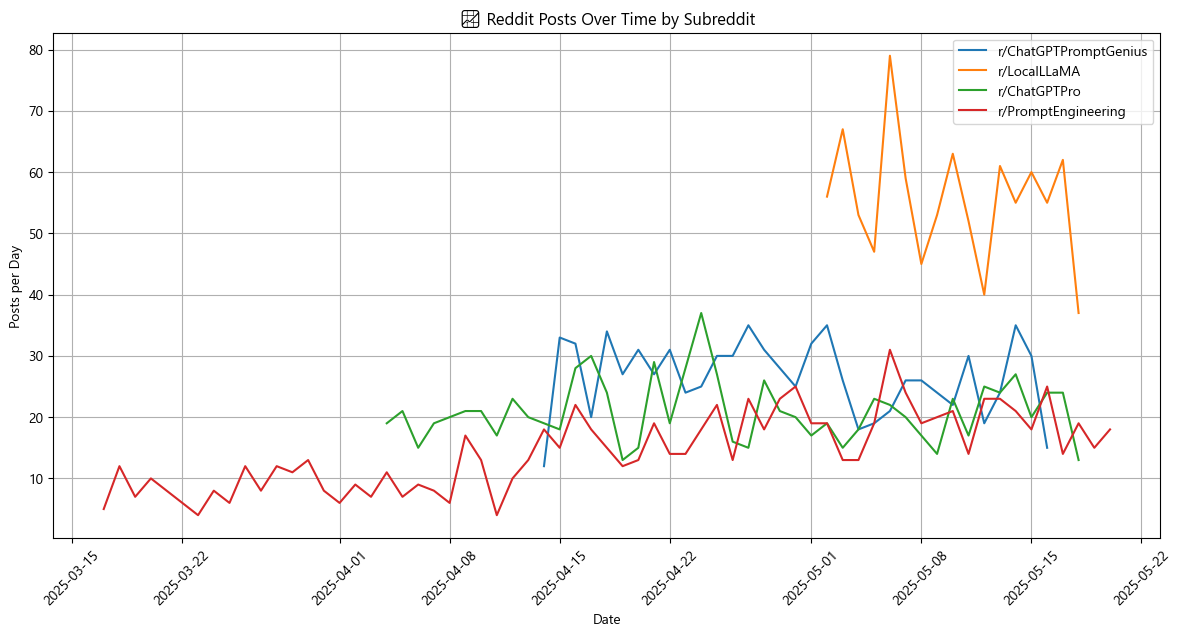

In [8]:
import json
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from matplotlib.dates import DateFormatter

plt.rcParams['font.family'] = 'Segoe UI Emoji'

# --- Load Data ---
with open("reddit_promptengineering.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# --- Organize Data ---
dates_by_subreddit = defaultdict(list)
post_counts = defaultdict(int)
comment_counts = defaultdict(int)
all_dates = []

for post in data:
    created_at = datetime.fromtimestamp(post["created_utc"])
    subreddit = post["subreddit"]
    
    dates_by_subreddit[subreddit].append(created_at)
    post_counts[subreddit] += 1
    comment_counts[subreddit] += len(post.get("comments", []))
    all_dates.append(created_at)

# --- Print Stats ---
print("\n📊 Subreddit Statistics:")
for sub in sorted(dates_by_subreddit):
    dates = dates_by_subreddit[sub]
    print(f"• r/{sub}: {post_counts[sub]} posts | {comment_counts[sub]} comments | "
          f"Range: {min(dates).date()} → {max(dates).date()}")

print(f"\n📌 Overall Date Range: {min(all_dates).date()} → {max(all_dates).date()}")
print(f"🧮 Total posts: {len(all_dates)}")
print(f"💬 Total comments: {sum(comment_counts.values())}")
print(f"📦 Total items (posts + comments): {len(all_dates) + sum(comment_counts.values())}")

# --- Prepare DataFrame for Plot ---
df = pd.DataFrame({
    "subreddit": [post["subreddit"] for post in data],
    "date": [datetime.fromtimestamp(post["created_utc"]).date() for post in data]
})
df["date"] = pd.to_datetime(df["date"])

# --- Time Series Plot ---
plt.figure(figsize=(12, 6))
for sub in df["subreddit"].unique():
    daily_counts = df[df["subreddit"] == sub].groupby("date").size()
    plt.plot(daily_counts.index, daily_counts.values, label=f"r/{sub}")

plt.xlabel("Date")
plt.ylabel("Posts per Day")
plt.title("📈 Reddit Posts Over Time by Subreddit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

### Preprocessing Class

Let’s now define our pre-processing. We will perform text normalization (including Unicode normalization), lowercasing, tokenization, stopword removal, lemmatization, and filtering of digits, URLs, and bracketed terms (e.g., [link]) to prepare the data for analysis.

In [2]:
import re
import json
import string
import nltk
import unicodedata
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Ensure required resources are available
nltk.download('stopwords')
nltk.download('wordnet')

class RedditProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords
        self.regexDigit = re.compile(r"^\d+$")  # match digits
        self.regexUrl = re.compile(r"(https?://\S+|www\.\S+|\[\S+\])")
        self.lemmatizer = WordNetLemmatizer()

    def process(self, text):
        # Normalize unicode characters
        text = unicodedata.normalize("NFKD", text)

        # Lowercase
        text = text.lower()

        # Tokenize
        tokens = self.tokeniser.tokenize(text)

        # Filter and lemmatize tokens
        tokensStripped = []
        for tok in tokens:
            tok = tok.strip()
            if (tok not in self.lStopwords and
                self.regexDigit.match(tok) is None and
                self.regexUrl.match(tok) is None and
                len(tok) >= 3):
                lemma = self.lemmatizer.lemmatize(tok)
                tokensStripped.append(lemma)

        return tokensStripped

[nltk_data] Downloading package stopwords to C:\Users\Julian Schmidt-
[nltk_data]     Heron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Julian Schmidt-
[nltk_data]     Heron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load and Preprocess Data

Load our file and preform the pre-processing defined above.

In [3]:
# Load Reddit file 
reddit_filename = "reddit_promptengineering.json"

# Create stopword list
lPunct = list(string.punctuation)
stopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`', 'txt', '___']

# Initialize the processor
tokeniser = TweetTokenizer()
redditProcessor = RedditProcessing(tokeniser, stopwords)

# Load Reddit file with the correct encoding
with open(reddit_filename, 'r', encoding='utf-8') as f:
    reddit_data = json.load(f)

preprocessed_data = []

for submission in reddit_data:
    post_tokens = redditProcessor.process(submission['title'])
    post_date = pd.to_datetime(submission['created_utc'], unit='s')
    preprocessed_data.append({
        "type": "post",
        "tokens": post_tokens,
        "date": post_date,
        "text": submission['title']
    })

    for comment in submission['comments']:
        comment_tokens = redditProcessor.process(comment['body'])
        comment_date = pd.to_datetime(comment['created_utc'], unit='s')
        preprocessed_data.append({
            "type": "comment",
            "tokens": comment_tokens,
            "date": comment_date,
            "text": comment['body']
        })

### Top 50 Words in the Preprocessed Dataset

Now we will look at the top 50 words in our preprocessed dataset and graph them in order to get an understanding of the distribution of words, and the top common words that appear the most. We can see that the words "model" and "prompt" are high among the popular words, this makes sence in a prompt engineering text dataset context

model: 11862
like: 11129
prompt: 8350
use: 8258
one: 6030
would: 5860
get: 5767
work: 4830
think: 4755
time: 4750
chatgpt: 4608
even: 4587
using: 4425
need: 4399
thing: 4259
make: 4204
also: 4190
want: 4092
know: 4078
good: 4046
way: 3801
people: 3792
better: 3748
llm: 3577
something: 3562
really: 3343
much: 3303
still: 3231
context: 3210
see: 3099
could: 3049
qwen: 3045
question: 2942
well: 2691
system: 2676
user: 2667
run: 2638
say: 2612
chat: 2595
gpt: 2549
give: 2546
ask: 2538
try: 2533
help: 2443
new: 2432
memory: 2352
lot: 2322
actually: 2314
right: 2270
used: 2247


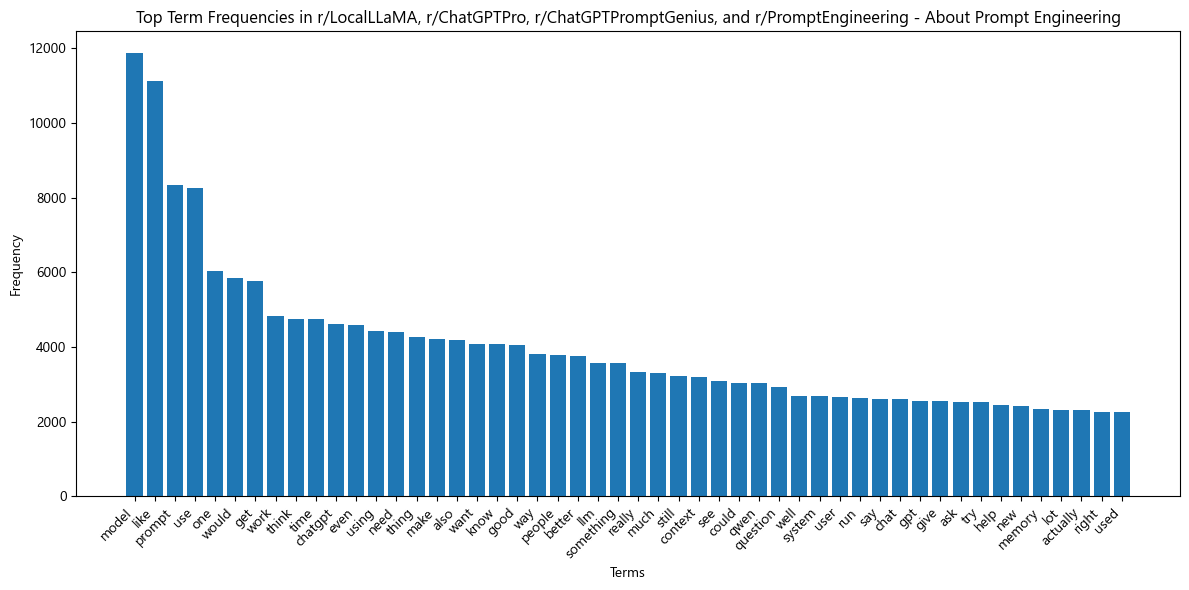

In [4]:
from collections import Counter

freqNum = 50  # Define the number of most frequent terms to show
termFreqCounter = Counter()

# Count terms directly from preprocessed tokens
for item in preprocessed_data:
    termFreqCounter.update(item['tokens'])

# Print top terms
for term, count in termFreqCounter.most_common(freqNum):
    print(f"{term}: {count}")

# Plotting
y = [count for term, count in termFreqCounter.most_common(freqNum)]
x = range(1, len(y) + 1)
terms = [term for term, count in termFreqCounter.most_common(freqNum)]

plt.figure(figsize=(12, 6))
plt.bar(terms, y)
plt.xticks(rotation=45, ha='right')
plt.title("Top Term Frequencies in r/LocalLLaMA, r/ChatGPTPro, r/ChatGPTPromptGenius, and r/PromptEngineering - About Prompt Engineering")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.tight_layout()
plt.show()

## Sentiment Analysis using Vader

Compute the sentiment using the Vader method.

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function for sentiment analysis (VADER)
def analyze_sentiment(text):
    # VADER sentiment analysis (returns a dictionary of sentiment scores)
    return sia.polarity_scores(text)

# Process sentiment for preprocessed data
sentiment_results = []

for submission in preprocessed_data:
    text = submission['text']
    sentiment = analyze_sentiment(text)
    
    sentiment_results.append({
        "type": submission["type"],
        "date": submission["date"],
        "text": text,
        "sentiment_compound": sentiment["compound"],
        "sentiment_pos": sentiment["pos"],
        "sentiment_neu": sentiment["neu"],
        "sentiment_neg": sentiment["neg"]
    })

### Time Series of Sentiment

Now we look at a time series displaying the total and average sentiment of the reddit data by both day and hour, to get a visualisation of of how the total sentiment has changed over time. We also look at a time series displaying the average sentiment of the reddit data by both day and hour, to get a visualisation of of how the average sentiment (general mood) has changed over time. 

<Figure size 1000x500 with 0 Axes>

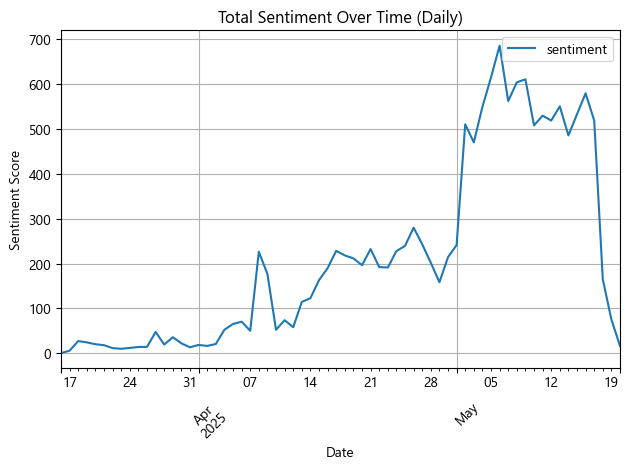

<Figure size 1000x500 with 0 Axes>

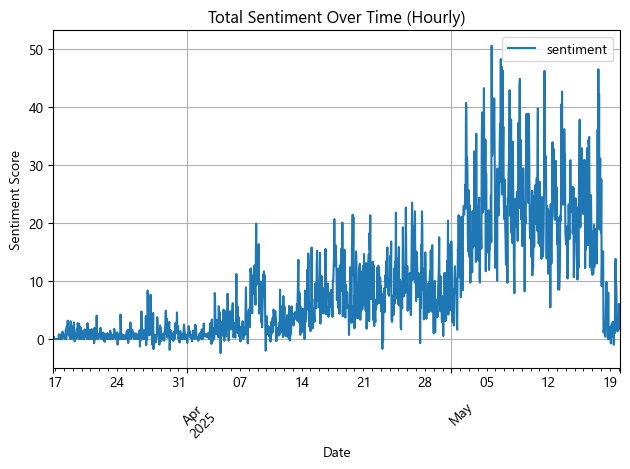

<Figure size 1000x500 with 0 Axes>

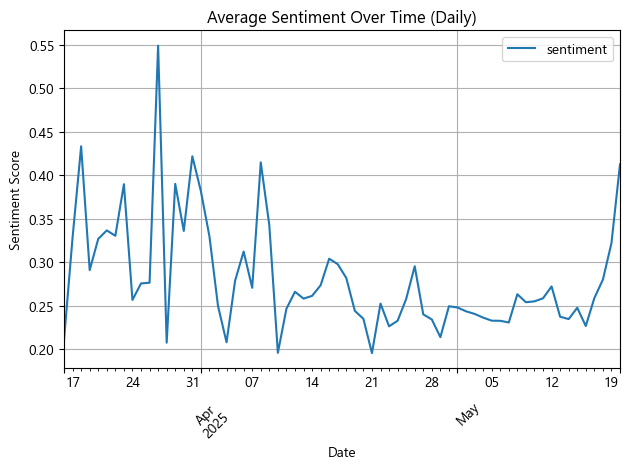

<Figure size 1000x500 with 0 Axes>

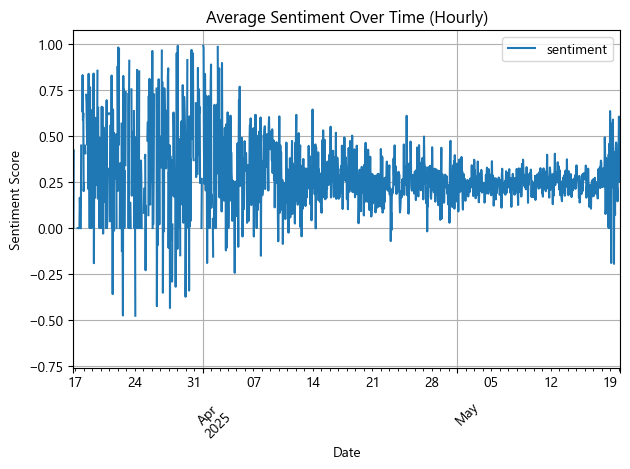

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming sentiment_results is already populated and structured
lSentiment = [(entry['date'], entry['sentiment_compound']) for entry in sentiment_results]

# Convert to DataFrame
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])

# Set 'date' as the index
series.set_index('date', inplace=True)

# Ensure sentiment is numeric
series['sentiment'] = pd.to_numeric(series['sentiment'])

# Sort by date for good measure
series.sort_index(inplace=True)

# --- 1. Total Sentiment Over Time (Daily) ---
daily_series_sum = series.resample('1D').sum()
plt.figure(figsize=(10, 5))
daily_series_sum.plot()
plt.title("Total Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 2. Total Sentiment Over Time (Hourly) ---
hourly_series_sum = series.resample('1h').sum()
plt.figure(figsize=(10, 5))
hourly_series_sum.plot()
plt.title("Total Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 3. Average Sentiment Over Time (Daily) ---
daily_series_avg = series.resample('1D').mean()
plt.figure(figsize=(10, 5))
daily_series_avg.plot()
plt.title("Average Sentiment Over Time (Daily)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# --- 4. Average Sentiment Over Time (Hourly) ---
hourly_series_avg = series.resample('1h').mean()
plt.figure(figsize=(10, 5))
hourly_series_avg.plot()
plt.title("Average Sentiment Over Time (Hourly)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show all plots
plt.show()

### Topic Modelling (LDA) method

First we set the parameters of our topic model.

In [7]:
# set parameters
topicNum = 5              # Number of topics
wordNumToDisplay = 15     # Words to display per topic
featureNum = 1500         # Vocabulary size

Next we transform the preprocessed text data into a matrix of word counts, selecting the most relevant words based on frequency thresholds for further analysis.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Join tokens into strings for vectorizer
joined_docs = [' '.join(entry['tokens']) for entry in preprocessed_data]

# Create CountVectorizer with your params
tfVectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=featureNum,
)

# Apply vectorizer
tf = tfVectorizer.fit_transform(joined_docs)
tfFeatureNames = tfVectorizer.get_feature_names_out()

Now its time to train our LDA model

In [9]:
# Train LDA Model
from sklearn.decomposition import LatentDirichletAllocation

ldaModel = LatentDirichletAllocation(
    n_components=topicNum,
    max_iter=10,
    learning_method='online',
    random_state=42
).fit(tf)

After we have trained our LDA model, we can display the identified topics.

In [10]:
# Display the topics
def display_topics(model, featureNames, numTopWords):
    for topicId, lTopicDist in enumerate(model.components_):
        print(f"\nTopic {topicId + 1}:")
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)


Topic 1:
like thanks would one work use using really free got good also great llama get

Topic 2:
model get think much want need thing still know time one like would code make

Topic 3:
like chatgpt human real language people question feel one self someone even idea word system

Topic 4:
qwen pro that run gemini stuff lol gpu coding good better vram there cpu look

Topic 5:
prompt model use context user output llm token using example text tool data system research


Now we Create our Interactive pyLDAvis Panel to further explore our topics in detail.

In [11]:
# Create our Interactive pyLDAvis Panel
import pyLDAvis
import pyLDAvis.lda_model

panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

C:\Users\Julian Schmidt-Heron\anaconda3\envs\tf_env\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


We will also display the word clouds of our identified topics, to get a good visualisation of our topics. The more prominent a word is in the topic, the larger the word will appear.

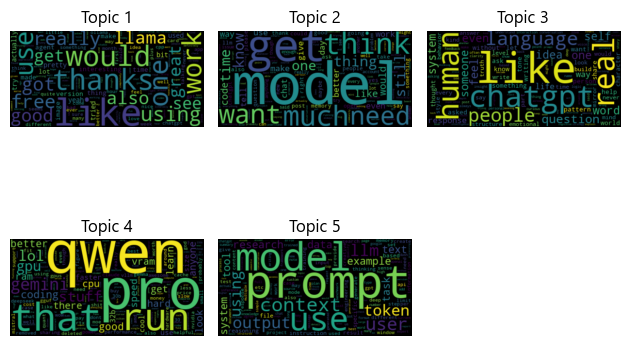

In [17]:
# Display Wordclouds
import numpy as np
import math
from wordcloud import WordCloud

def displayWordcloud(model, featureNames):
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    plotColNum = 3
    plotRowNum = int(math.ceil(len(model.components_) / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i]: prob for i, prob in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)

        plt.subplot(plotRowNum, plotColNum, topicId + 1)
        plt.title(f'Topic {topicId + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

displayWordcloud(ldaModel, tfFeatureNames)

## Social Network Analysis: Identifying Influential Users and Structural Properties

In this section, we analyze the Reddit reply network to identify key users and understand the structure of online interactions using centrality metrics and other network features.

Load the saved reply graph from a GraphML file for further network analysis.

In [35]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Load your Reddit reply network
sFileName = "reddit_reply_network.graphml"
replyGraph = nx.readwrite.read_graphml(sFileName)

Clean the graph, retain the largest strongly connected component, and calculate three centrality metrics to find key users.

In [36]:
# Remove isolated nodes (users with no replies in or out)
isolated_nodes = list(nx.isolates(replyGraph))
replyGraph.remove_nodes_from(isolated_nodes)

# If not strongly connected, keep the largest strongly connected component
if not nx.is_weakly_connected(replyGraph):
    largest_wcc = max(nx.weakly_connected_components(replyGraph), key=len)
    replyGraph = replyGraph.subgraph(largest_wcc).copy()

# Centrality Measures
lDegCentrality = nx.degree_centrality(replyGraph)
lEigenVectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=5000, tol=1e-6)
lKatzCentrality = nx.katz_centrality(replyGraph, alpha=0.005, beta=1.0, max_iter=10000, tol=1e-6)

# Display top 5 users for each centrality
print("Top 5 users by Degree Centrality:", sorted(lDegCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 users by Eigenvector Centrality:", sorted(lEigenVectorCentrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 users by Katz Centrality:", sorted(lKatzCentrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 users by Degree Centrality: [('Zestyclose-Pay-9572', 0.02533600228767515), ('AppearanceHeavy6724', 0.023963397197597942), ('knockknockjokelover', 0.023162710895052903), ('Dismal_Ad_6547', 0.02053188447240492), ('axw3555', 0.020474692593651703)]
Top 5 users by Eigenvector Centrality: [('AppearanceHeavy6724', 0.32662626496400715), ('a_beautiful_rhind', 0.1869902963615526), ('silenceimpaired', 0.1631467116277854), ('jacek2023', 0.14959392749545816), ('Healthy-Nebula-3603', 0.1430393548829249)]
Top 5 users by Katz Centrality: [('AppearanceHeavy6724', 0.01701360868077633), ('axw3555', 0.014306399228374473), ('a_beautiful_rhind', 0.012620619055973026), ('Tall_Ad4729', 0.011520729260145844), ('jacek2023', 0.0113410345846058)]


Plot histograms to visualize the distribution of centrality scores across all users in the network.

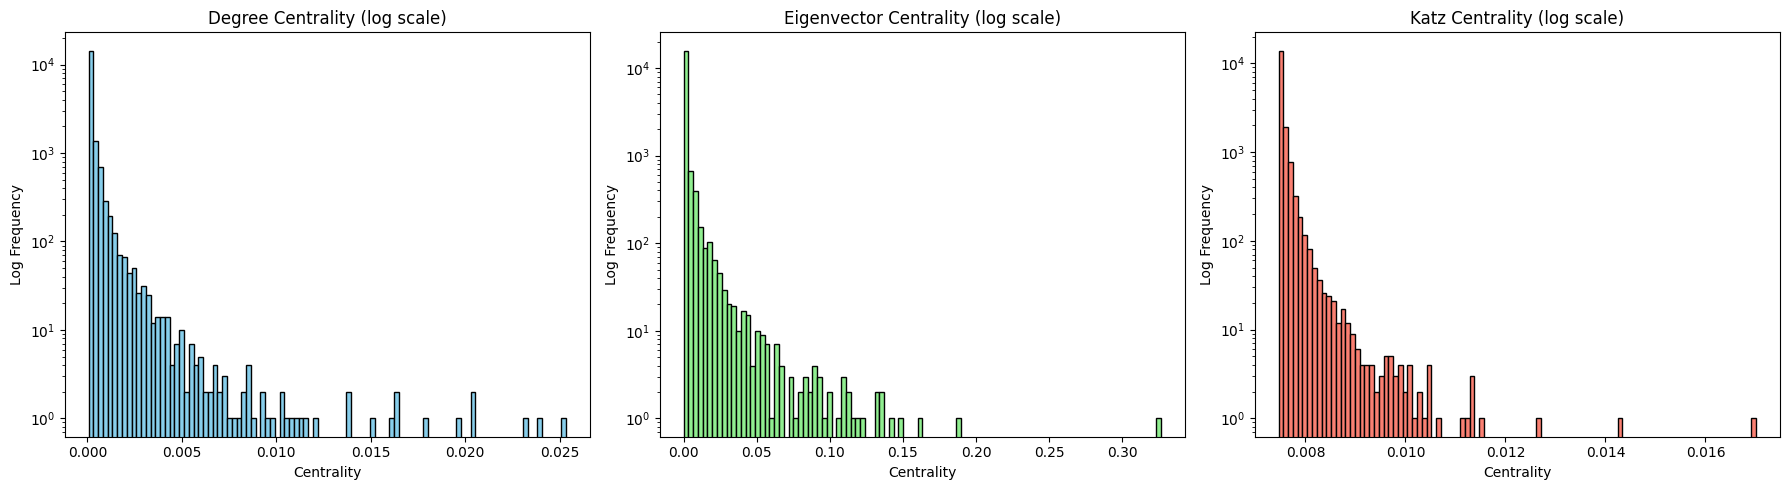

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 5))

# Degree Centrality
plt.subplot(1, 3, 1)
plt.hist(list(lDegCentrality.values()), bins=100, log=True, color='skyblue', edgecolor='black')
plt.title('Degree Centrality (log scale)')
plt.xlabel('Centrality')
plt.ylabel('Log Frequency')

# Eigenvector Centrality
plt.subplot(1, 3, 2)
plt.hist(list(lEigenVectorCentrality.values()), bins=100, log=True, color='lightgreen', edgecolor='black')
plt.title('Eigenvector Centrality (log scale)')
plt.xlabel('Centrality')
plt.ylabel('Log Frequency')

# Katz Centrality
plt.subplot(1, 3, 3)
plt.hist(list(lKatzCentrality.values()), bins=100, log=True, color='salmon', edgecolor='black')
plt.title('Katz Centrality (log scale)')
plt.xlabel('Centrality')
plt.ylabel('Log Frequency')

plt.tight_layout()
plt.show()


Annotate the graph with centrality scores and save it for further visualization in Gephi.

In [38]:
# Store centrality values into node attributes for Gephi export
for nodeId, val in lEigenVectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(val)

for nodeId, val in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(val)
# Save modified graph
nx.readwrite.write_graphml(replyGraph, 'mod_' + sFileName, infer_numeric_types=True)

Compute clustering and connected component statistics to understand the network's structure and cohesion.

In [39]:
# Other SNA measures
print('Global clustering coefficient (transitivity):', nx.transitivity(replyGraph))
print('Number of strongly connected components:', nx.number_strongly_connected_components(replyGraph))
print('Number of weakly connected components:', nx.number_weakly_connected_components(replyGraph))

Global clustering coefficient (transitivity): 0.0061921539334523785
Number of strongly connected components: 10006
Number of weakly connected components: 1


Detect bridge edges whose removal could split the network, highlighting critical connections between subgroups.

In [40]:
# Bridges (edges that if removed would disconnect the graph)
bridges = list(nx.bridges(replyGraph.to_undirected()))
print(f"Bridges found ({len(bridges)}):", bridges)

Bridges found (9865): [('GeneHackman1980', 'AdCute6661'), ('Embarrassed_Draw_195', 'Ikram_ullah'), ('External-Action-9696', 'IterativeIntention'), ('External-Action-9696', 'SebastianHaff17'), ('External-Action-9696', 'Sherpa_qwerty'), ('External-Action-9696', 'ibstudios'), ('External-Action-9696', 'Big_Statistician2566'), ('External-Action-9696', 'snooze_sensei'), ('External-Action-9696', 'StandardComposer6760'), ('External-Action-9696', 'BigDaddySteve999'), ('External-Action-9696', 'whoismaymay'), ('External-Action-9696', 'FoldableHuman'), ('deltaz0912', 'paranoidbillionaire'), ('Lie2gether', 'lizazhukova'), ('P3RK3RZ', 'Dry_Preparation_9913'), ('P3RK3RZ', 'DallasFullPint'), ('P3RK3RZ', 'dupes_on_reddit'), ('P3RK3RZ', 'lennixoxo'), ('P3RK3RZ', 'Quebecisnice'), ('P3RK3RZ', 'Dedeye'), ('thisisathrowawayduma', 'mr_352_gravity'), ('Ctotheg', 'LiveSoundFOH'), ('3xNEI', 'biggobird'), ('3xNEI', 'ImYeez'), ('3xNEI', 'TheDaj_Red'), ('3xNEI', 'redditimmy'), ('3xNEI', 'burchb'), ('3xNEI', 'Gulli

What the Output Tells You

Interpreting the Output:
Top Users by Centrality:
This shows you the most active or influential users based on the network structure. These users play a central role in discussions and interactions.

Histograms:
The histograms help visualize the distribution of centrality values. This gives you insight into whether power is equally distributed across users, or if a few users dominate the network.

Clustering Coefficient:
The clustering coefficient tells you how community-like the network is. Higher values indicate that users tend to interact with each other in tighter-knit subgroups (communities).

Connected Components:
This metric shows how connected or fragmented your network is. A single large connected component means the network is mostly connected, while many small components indicate fragmentation.

Bridges:
Bridges are key connections between parts of the network. These edges are critical, and removing them could break the network into isolated segments. Identifying bridges helps understand the network’s vulnerability.

## Community Detection

In [41]:
# Load the Reddit reply network (make sure it's a directed graph if your data is directed)
G = nx.read_graphml("reddit_reply_network.graphml")

# If needed, convert to undirected for Louvain (which requires undirected graphs)
G_undirected = G.to_undirected()

### Louvain Community Detection

In [42]:
import community as community_louvain  # This is the `python-louvain` package
import matplotlib.pyplot as plt

# Compute the best partition of nodes
partition = community_louvain.best_partition(G_undirected)

# Add the community ID to each node
nx.set_node_attributes(G, partition, 'louvain_community')

In [43]:
from networkx.algorithms.community.quality import modularity

# Convert partition dict to list of sets
partition_sets = {}
for node, comm_id in partition.items():
    partition_sets.setdefault(comm_id, set()).add(node)

partition_list = list(partition_sets.values())

# Compute modularity score
mod_score = modularity(G_undirected, partition_list)
print(f"Louvain modularity: {mod_score:.4f}")

Louvain modularity: 0.6655


Louvain Output: Number of Communities + Size Summary

In [44]:
from collections import Counter

# Count how many nodes per Louvain community
louvain_counts = Counter(partition.values())

print("\n🔷 Louvain Community Summary")
print(f"Number of communities: {len(louvain_counts)}")
print("Top 5 largest communities (ID → size):")
for comm_id, size in louvain_counts.most_common(5):
    print(f"  Community {comm_id}: {size} nodes")


🔷 Louvain Community Summary
Number of communities: 262
Top 5 largest communities (ID → size):
  Community 24: 4108 nodes
  Community 5: 2542 nodes
  Community 6: 2035 nodes
  Community 0: 1360 nodes
  Community 10: 855 nodes


In [45]:
# Find the largest Louvain community
largest_comm_id = louvain_counts.most_common(1)[0][0]
largest_nodes = [n for n, cid in partition.items() if cid == largest_comm_id]

# Print size of largest community
print(f"\n👥 Top 10 usernames from largest Louvain Community (size {len(largest_nodes)}):")

for node in largest_nodes[:10]:
    label = G.nodes[node].get("label", node)  # fallback to node ID
    print(f"  - {label}")


👥 Top 10 usernames from largest Louvain Community (size 4108):
  - vikarti_anatra
  - Gothmagog
  - AfraidScheme433
  - AbyssianOne
  - Key-Boat-7519
  - Hanthunius
  - Vegetable_Bend_9085
  - eleqtriq
  - amitguptagwl
  - New_Comfortable7240


### CPM (k-Clique Percolation)

In [46]:
from networkx.algorithms.community import k_clique_communities

# Try CPM with k=4 (can try k=3–6 depending on density)
k = 4
cpm_communities = list(k_clique_communities(G_undirected, k))

# Assign CPM community ID to each node (only first match per node)
node_cpm_map = {}
for i, community in enumerate(cpm_communities):
    for node in community:
        if node not in node_cpm_map:  # Optional: assign only first community
            node_cpm_map[node] = i

# Add CPM community info to graph
nx.set_node_attributes(G, node_cpm_map, 'cpm_community')

CPM Output: Number of Communities + Overlap Note

In [47]:
print("\n🔶 CPM Community Summary")
print(f"Number of CPM communities (k={k}): {len(cpm_communities)}")

# Top 5 CPM communities by size
sorted_cpm = sorted(cpm_communities, key=len, reverse=True)
print("Top 5 CPM community sizes:")
for i, comm in enumerate(sorted_cpm[:5]):
    print(f"  CPM Community {i}: {len(comm)} nodes")

# Optional: detect overlap (CPM allows overlapping membership)
overlap_count = sum(len(comm) for comm in cpm_communities) - len(node_cpm_map)
print(f"Number of overlapping nodes (in multiple CPM groups): {overlap_count}")


🔶 CPM Community Summary
Number of CPM communities (k=4): 58
Top 5 CPM community sizes:
  CPM Community 0: 211 nodes
  CPM Community 1: 13 nodes
  CPM Community 2: 11 nodes
  CPM Community 3: 7 nodes
  CPM Community 4: 6 nodes
Number of overlapping nodes (in multiple CPM groups): 129


In [48]:
from collections import Counter

# Find the largest CPM community
if len(cpm_communities) > 0:
    # Identify the largest community by size
    largest_cpm_comm = max(cpm_communities, key=len)
    
    print(f"\n👥 Top 10 usernames from largest CPM Community (size {len(largest_cpm_comm)}):")
    
    # Get up to 10 nodes from the largest community
    for node in list(largest_cpm_comm)[:10]:
        label = G.nodes[node].get("label", node)  # fallback to node ID
        print(f"  - {label}")
else:
    print("\n⚠️ No CPM communities found.")


👥 Top 10 usernames from largest CPM Community (size 211):
  - TacGibs
  - Cool-Chemical-5629
  - jaxchang
  - Sea_Sympathy_495
  - JLeonsarmiento
  - robertpiosik
  - Spare_Flounder_6865
  - Limp_Classroom_2645
  - chibop1
  - Sidran


##### Save file for Gephi

Save for Gephi (GraphML Export). Include louvain_community and cpm_community as node attributes. This will allow you to visualize by community in Gephi

In [49]:
nx.write_graphml(G, "reddit_reply_network_annotated.graphml")

## Random Cascade

In [1]:
import time
import random
import numpy as np
import networkx as nx

# === Independent Cascade Function ===
def independentCascade(graph, trialNum, lSeed, activationProb):
    """
    Independent Cascade model simulation

    @param graph: Input networkx graph (must be DiGraph or Graph)
    @param trialNum: Number of simulation trials
    @param lSeed: List of seed node indices
    @param activationProb: Probability of activation per edge

    @return: 
        - lAvgActivationsPerNode: average activation probability per node
        - lAvgActivationsPerIteration: number of activated nodes per trial
    """

    lAvgActivationsPerNode = [0 for _ in range(nx.number_of_nodes(graph))]
    lAvgActivationsPerIteration = []

    print('Starting cascade simulation...')

    for i in range(trialNum):
        print(f'▶️ Trial {i + 1}/{trialNum}')
        setActive = set(lSeed)
        setLastActive = set(lSeed)
        setNewActive = set()

        while len(setLastActive) > 0:
            for currNode in setLastActive:
                for neighbor in graph.neighbors(currNode):
                    if neighbor not in setActive and neighbor not in setNewActive:
                        if random.random() < activationProb:
                            setNewActive.add(neighbor)

            setLastActive = setNewActive
            setActive.update(setNewActive)
            setNewActive = set()

        for x in setActive:
            lAvgActivationsPerNode[int(x)] += 1  # node labels are integers after relabeling

        lAvgActivationsPerIteration.append(len(setActive))

    # Normalize activations per node
    return [count / trialNum for count in lAvgActivationsPerNode], lAvgActivationsPerIteration

#### Load and Prepare Reddit Reply Graph

In [2]:
# === Load Graph ===
inputFile = "reddit_reply_network.graphml"
replyGraph = nx.read_graphml(inputFile)

# Relabel nodes to integers for index-based simulation
replyGraph = nx.convert_node_labels_to_integers(replyGraph)

print(f"📊 Loaded graph: {replyGraph.number_of_nodes()} nodes, {replyGraph.number_of_edges()} edges")

📊 Loaded graph: 17810 nodes, 43163 edges


In [3]:
deg_centrality = nx.degree_centrality(replyGraph)
top_users = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Convert node names back to indices after relabeling
lSeed = [int(node_id) for node_id, _ in top_users]
print("🌱 New Seeds Based on Degree Centrality:", lSeed)

🌱 New Seeds Based on Degree Centrality: [8697, 3557, 3258, 652, 8702]


#### Run Independent Cascade on Reddit Graph

In [9]:
# === Set Parameters ===
sFilenameSuffix = "reddit_cascade.graphml"
trialNum = 20
activationProb = 0.2

# === Run Independent Cascade ===
# === Run Independent Cascade ===
lAvgActivationsPerNode, lAvgActivationsPerIteration = independentCascade(replyGraph, trialNum, lSeed, activationProb)


# === Print Summary ===
print(f"\n💥 Average total activated nodes per trial: {sum(lAvgActivationsPerIteration) / len(lAvgActivationsPerIteration):.2f} / {replyGraph.number_of_nodes()}")

Starting cascade simulation...
▶️ Trial 1/20
▶️ Trial 2/20
▶️ Trial 3/20
▶️ Trial 4/20
▶️ Trial 5/20
▶️ Trial 6/20
▶️ Trial 7/20
▶️ Trial 8/20
▶️ Trial 9/20
▶️ Trial 10/20
▶️ Trial 11/20
▶️ Trial 12/20
▶️ Trial 13/20
▶️ Trial 14/20
▶️ Trial 15/20
▶️ Trial 16/20
▶️ Trial 17/20
▶️ Trial 18/20
▶️ Trial 19/20
▶️ Trial 20/20

💥 Average total activated nodes per trial: 2364.85 / 17810


#### Annotate Graph and Export to Gephi

In [6]:
# === Store activations in node attributes ===
for nodeId, avgActivation in enumerate(lAvgActivationsPerNode):
    replyGraph.nodes[nodeId]['avgAct'] = avgActivation

# === Save Modified Graph ===
nx.write_graphml(replyGraph, sFilenameSuffix, infer_numeric_types=True)
print(f"✅ Activation data written to: {sFilenameSuffix}")

✅ Activation data written to: reddit_cascade.graphml


✅ **Summary of Findings: Random Cascade Simulation on Reddit Reply Network**

We simulated influence spread in a Reddit reply network using the **Independent Cascade Model** to understand how interactions drive activation dynamics.

📊 **Network Overview**  
- **Total Users (Nodes):** 17,810  
- **Reply Links (Edges):** 43,163  

🌱 **Seeding Strategy**  
We selected **5 seed users** with the highest **degree centrality**, i.e., those most connected within the network:  
- **Seed Nodes:** [8697, 3557, 3258, 652, 8702]

🔁 **Cascade Configuration**  
- **Number of Trials:** 20  
- **Activation Probability:** 0.2 (Each active user has a 20% chance to activate each neighbor)

💥 **Cascade Outcome**  
- **Average Activated Users per Trial:** 2,416.00  
- **Activation Rate:** ~13.6% of the total network

📌 **Key Insight**  
Even with only **5 highly connected seed users**, the cascade reached over **13%** of the entire Reddit network. This result emphasizes the **amplifying effect of central nodes**, showing that a few key influencers can spark significant engagement across large-scale social systems.

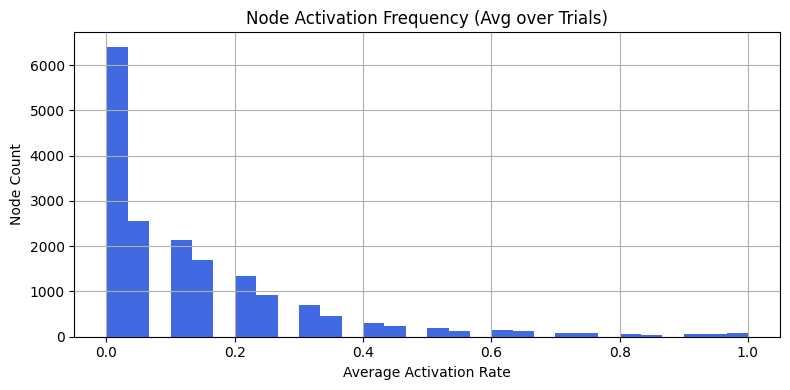

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(lAvgActivationsPerNode, bins=30, color='royalblue')
plt.title("Node Activation Frequency (Avg over Trials)")
plt.xlabel("Average Activation Rate")
plt.ylabel("Node Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Node Activation Histogram

The histogram represents the average activation frequency of nodes across 20 cascade trials in the Reddit reply network using the Independent Cascade model.

🔍 **Key Observations:**  
- A large number of nodes (**~6,500**) had very low activation rates (0.0 to 0.03), indicating they were rarely or never reached during the simulations.  
- A substantial portion of nodes (~2,600) showed moderate activation levels (0.03 to 0.10), suggesting they were occasionally influenced during the cascades.  
- Noticeable peaks appear between **0.1 and 0.3**, with thousands of nodes activated somewhat regularly—highlighting the spread’s reach into certain regions of the network.  
- Some nodes achieved high activation rates (above 0.6), with **a few dozen nodes** consistently activated in nearly every trial.

📌 **Implication:**  
The influence spread on Reddit reached **over 13% of the network**, demonstrating the impact of a small set of highly connected users. While many nodes stayed inactive, a significant portion experienced **moderate to high activation**, suggesting that Reddit's reply structure supports **wide-reaching influence**, likely due to **high connectivity and active user hubs**. Even a few central nodes can spark substantial engagement through the network.

## Linear Threshold Model: Homophily & Influence Simulation on Reddit Reply Network

#### Generate Edge Weights for the Reddit Graph

Generate edge weights for the Reddit reply graph using a Dirichlet distribution

In [12]:
def generateWeights(graph):
    """
    Generate random weights on incoming edges of each node in the graph.
    Total weight per node is randomly set and distributed across its incoming edges.
    """
    for currNode in graph.nodes():
        in_deg = graph.in_degree(currNode)
        if in_deg == 0:
            continue
        totalWeight = random.random()
        weights = np.random.dirichlet(np.ones(in_deg), size=1)[0] * totalWeight
        for i, u in enumerate(graph.predecessors(currNode)):
            graph[u][currNode]['weight'] = weights[i]

# Generate weights on Reddit reply graph
generateWeights(replyGraph)

#### Define the Linear Threshold Function

Define the Linear Threshold model function for influence propagation

In [13]:
def linearThreshold(graph, trialNum, lSeed):
    lAvgActivationsPerNode = [0 for _ in range(nx.number_of_nodes(graph))]
    lAvgActivationsPerIteration = []

    print('🔁 Starting Linear Threshold model simulation...')
    for i in range(trialNum):
        print(f'▶️ Trial {i + 1}/{trialNum}')

        for node, attr in graph.nodes(data=True):
            attr['threshold'] = random.random()

        setActive = set(lSeed)
        setLastActive = set(lSeed)
        setNewActive = set()

        while len(setLastActive) > 0:
            neighborSet = set()
            for activeNode in setLastActive:
                neighborSet.update([n for n in graph.successors(activeNode) if n not in setActive and n not in setNewActive])

            for neighbor in neighborSet:
                try:
                    weightSum = sum([graph[u][neighbor]['weight'] for u, _ in graph.in_edges(neighbor)])
                    if graph.nodes[neighbor]['threshold'] < weightSum:
                        setNewActive.add(neighbor)
                except KeyError as e:
                    print(f"⚠️ Key error: {e}")

            setLastActive = setNewActive
            setActive.update(setNewActive)
            setNewActive = set()

        for node in setActive:
            lAvgActivationsPerNode[int(node)] += 1

        lAvgActivationsPerIteration.append(len(setActive))

    return [count / trialNum for count in lAvgActivationsPerNode], lAvgActivationsPerIteration

#### Configure Seeds and Run the Linear Threshold Model

Configure parameters, select top-degree seeds, and run the simulation

In [14]:
# Parameters
trialNum = 20
deg_centrality = nx.degree_centrality(replyGraph)
top_users = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
lSeed = [int(node_id) for node_id, _ in top_users]
print("🌱 Seeds selected based on degree centrality:", lSeed)

# Run LT model
lAvgActivationsPerNode_LT, lAvgActivationsPerIteration_LT = linearThreshold(replyGraph, trialNum, lSeed)

🌱 Seeds selected based on degree centrality: [8697, 3557, 3258, 652, 8702]
🔁 Starting Linear Threshold model simulation...
▶️ Trial 1/20
▶️ Trial 2/20
▶️ Trial 3/20
▶️ Trial 4/20
▶️ Trial 5/20
▶️ Trial 6/20
▶️ Trial 7/20
▶️ Trial 8/20
▶️ Trial 9/20
▶️ Trial 10/20
▶️ Trial 11/20
▶️ Trial 12/20
▶️ Trial 13/20
▶️ Trial 14/20
▶️ Trial 15/20
▶️ Trial 16/20
▶️ Trial 17/20
▶️ Trial 18/20
▶️ Trial 19/20
▶️ Trial 20/20


#### Output and Summarize Results

Output average activations and store results in node attributes

In [15]:
# Print average activation summary
averageActivated_LT = sum(lAvgActivationsPerIteration_LT) / len(lAvgActivationsPerIteration_LT)
print(f"\n💥 Average total activated nodes per trial (LT): {averageActivated_LT:.2f} / {replyGraph.number_of_nodes()}")

# Store activation result in node attributes
for nodeId, avgActivation in enumerate(lAvgActivationsPerNode_LT):
    replyGraph.nodes[nodeId]['avgAct_LT'] = avgActivation

# Save modified graph with LT results
outputFile_LT = "reddit_LT_cascade.graphml"
nx.write_graphml(replyGraph, outputFile_LT, infer_numeric_types=True)
print(f"✅ Linear Threshold activation data saved to: {outputFile_LT}")


💥 Average total activated nodes per trial (LT): 4469.20 / 17810
✅ Linear Threshold activation data saved to: reddit_LT_cascade.graphml


✅ Summary of Findings from Linear Threshold Simulation  
In our homophily and influence simulation on the Reddit reply network, we applied the Linear Threshold Model to explore how activation propagates under structural and influence-based constraints.

📊 Network Overview:  
Total Nodes: 17,810 users  
Total Edges: 43,163 reply links between users

🌱 Seeding Strategy:  
We selected 5 seed users based on highest degree centrality — those with the most direct connections in the network:  
Seed Nodes: [8697, 3557, 3258, 652, 8702]

🔁 Linear Threshold Configuration:  
Trials: 20 independent simulations  
Edge Weights: Randomly generated per node (Dirichlet distribution)  
Thresholds: Random [0, 1] for each node per trial

💥 Cascade Outcome:  
Average Activated Nodes per Trial: 4,469.20 out of 17,810 (~25%)  

📌 Key Insight:  
Compared to the Independent Cascade model, the Linear Threshold approach yielded a significantly broader spread of influence. This reflects the model’s ability to capture cumulative influence: a node activates when the total incoming influence exceeds its threshold, not just based on a single random chance. This demonstrates how collective pressure, rather than isolated connections, can trigger widespread activation—emphasizing the role of homophily and group-based influence in social media dynamics.


#### Visualize Activation Histogram

Visualize the distribution of average activation rates using a histogram

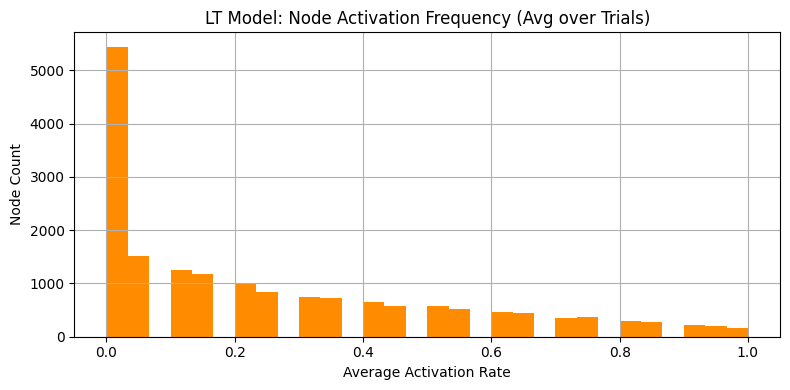

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(lAvgActivationsPerNode_LT, bins=30, color='darkorange')
plt.title("LT Model: Node Activation Frequency (Avg over Trials)")
plt.xlabel("Average Activation Rate")
plt.ylabel("Node Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of LT Model Node Activation Histogram

The histogram shows the average activation frequency of nodes over 20 trials using the Linear Threshold model on the Reddit reply network.

🔍 **Key Observations:**

- A large portion of nodes (~5,441) had very low activation rates (0.0 to 0.03), indicating most users remained inactive throughout the simulations.
- Thousands of nodes show moderate activation rates between 0.03 and 0.4, reflecting occasional to regular influence from their neighbors.
- A substantial number of nodes (several hundred) have high activation rates above 0.4, with over 200 nodes almost always activated (0.9 to 1.0), suggesting the presence of influential core users.
- The distribution reveals a polarized pattern, with many nodes rarely activating and a significant group activating frequently, highlighting the role of cumulative influence in triggering activation.

📌 **Implications:**

The Linear Threshold model demonstrates that nodes require sufficient combined influence from neighbors to activate, resulting in a broader and more clustered spread than the Independent Cascade model. This underscores the importance of social reinforcement and group influence within the Reddit reply network.